# Build Agents from Scratch: Fundamental Web Search Agent 
* Source: [Medium Blog](https://medium.com/towards-data-science/genai-with-python-build-agents-from-scratch-complete-tutorial-4fc1e084e2ec) thanks to [@mdipietro09](https://github.com/mdipietro09)

In [1]:
import ollama
from requests.exceptions import ConnectionError

try:
    # Check if model exists
    try:
        ollama.show('llama3')
    except ollama.ResponseError:
        print("Pulling llama3 model...")
        ollama.pull('llama3')
        print("Model pulled successfully!")

    # Now use the model
    q = '''who died on September 9, 2024?'''
    res = ollama.chat(
        model='llama3',
        messages=[{"role": "user", "content": q}]
    )
    print(res['message']['content'])
    
except ConnectionError as e:
    print(f"Connection error: {e}. Ensure Ollama is running - open the app or run 'ollama serve'")
except Exception as e:
    print(f"Error: {e}")

I'm so sorry to say that I don't have the information you're looking for. September 9, 2024, is in the future, and as of my training data cutoff in December 2022, there wasn't any public information available about people who might pass away on that specific date.

However, if you'd like to know about notable individuals who passed away on September 9th throughout history, I can provide you with some information. Please let me know!


In [3]:
from pprint import pprint
pprint(res)

ChatResponse(model='llama3', created_at='2025-02-22T09:51:47.01551Z', done=True, done_reason='stop', total_duration=24804531875, load_duration=801132833, prompt_eval_count=21, prompt_eval_duration=14504000000, eval_count=98, eval_duration=9480000000, message=Message(role='assistant', content="I'm so sorry to say that I don't have the information you're looking for. September 9, 2024, is in the future, and as of my training data cutoff in December 2022, there wasn't any public information available about people who might pass away on that specific date.\n\nHowever, if you'd like to know about notable individuals who passed away on September 9th throughout history, I can provide you with some information. Please let me know!", images=None, tool_calls=None))


In [13]:
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun

@tool("tool_browser")
def tool_browser(q: str) -> str:
    """Search on DuckDuckGo browser by passing the input `q`"""
    return DuckDuckGoSearchRun().run(q)

# test
print(tool_browser(q))

Famous deaths in September 2024. Learn about 55 historical figures, notable people and celebrities who died in Sep 2024 like Pete Rose, James Earl Jones and Kris Kristofferson. The following is a list of notable deaths in September 2024. Entries for each day are listed alphabetically by surname. A typical entry lists information in the following sequence: Name, age, country of citizenship at birth, subsequent country of citizenship (if applicable), reason for notability, cause of death (if known), and reference. ... What happened on September 9, 2024. Browse historical events, famous birthdays and notable deaths from Sep 9, 2024 or search by date, day or keyword. Menu. Channels On This Day. Calendar; Search; September 2024. Events; ... Died in 2024 2024 Highlights. About September 9, 2024. Day of the Week: Monday Search in the United States of people who died on September 9, 2024 obituaries and condolences. Find an obituary, get service details, leave condolence messages or send flower

In [14]:
def browser(q:str) -> str:
    """Search on DuckDuckGo browser by passing the input `q`"""
    return DuckDuckGoSearchRun().run(q)

In [15]:
@tool("final_answer")
def final_answer(text:str) -> str:
    """Returns a natural language response to the user by passing the input `text`. 
    You should provide as much context as possible and specify the source of the information.
    """
    return text

In [38]:
prompt = """
You know everything, you must answer every question from the user, you can use the list of tools provided to you.
Your goal is to provide the user with the best possible answer, including key information about the sources and tools used.

Note, when using a tool, you provide the tool name and the arguments to use in JSON format. 
For each call, you MUST ONLY use one tool AND the response format must ALWAYS be in the pattern:
```json
{"name":"<tool_name>", "parameters": {"<tool_input_key>":<tool_input_value>}}
```
Remember, do NOT use any tool with the same query more than once.
Remember, if the user doesn't ask a specific question, you MUST use the `final_answer` tool directly.

Every time the user asks a question, you take note of some keywords in the memory.
Every time you find some information related to the user's question, you take note of some keywords in the memory.

You should aim to collect information from a diverse range of sources before providing the answer to the user. 
Once you have collected plenty of information to answer the user's question use the `final_answer` tool.
"""

In [17]:
dic_tools = {"tool_browser":tool_browser, 
             "final_answer":final_answer}

str_tools = "\n".join([str(n+1)+". `"+str(v.name)+"`: "+str(v.description) for n,v in enumerate(dic_tools.values())])

prompt_tools = f"You can use the following tools:\n{str_tools}"
print(prompt_tools)

You can use the following tools:
1. `tool_browser`: Search on DuckDuckGo browser by passing the input `q`
2. `final_answer`: Returns a natural language response to the user by passing the input `text`. 
You should provide as much context as possible and specify the source of the information.


In [19]:
# LLM deciding what tool to use
llm_res = ollama.chat(
    model='llama3',
    messages=[{"role":"system", "content":prompt+"\n"+prompt_tools},
              {"role":"user", "content":"hello"}
             ], format="json")

pprint(llm_res)

ChatResponse(model='llama3', created_at='2025-02-22T10:08:50.721054Z', done=True, done_reason='stop', total_duration=16227515750, load_duration=826937542, prompt_eval_count=320, prompt_eval_duration=10614000000, eval_count=45, eval_duration=4373000000, message=Message(role='assistant', content='{"name":"final_answer", "parameters":{"text":"Hello! I\'m here to help you with your questions. Please feel free to ask me anything, and I\'ll do my best to provide a helpful response."}}', images=None, tool_calls=None))


In [20]:
# LLM deciding what tool to use (output format = json)
llm_res = ollama.chat(
    model='llama3',
    messages=[{"role":"system", "content":prompt+"\n"+prompt_tools},
              {"role":"user", "content":q}
             ], format="json")

llm_res["message"]["content"]

'{"name": "tool_browser", "parameters": {"q": "people who died on September 9 2024"}}'

In [22]:
# LLM with context
import json

tool_input = json.loads(llm_res["message"]["content"])["parameters"]["q"]

context = tool_browser(tool_input)
print("tool output:\n", context)

llm_output = ollama.chat(
    model='llama3',
    messages=[{"role":"system", "content":"Give the most accurate answer using the folling information:\n"+context},
              {"role":"user", "content":q}
             ])

print("\nllm output:\n", llm_output["message"]["content"])

tool output:
 Famous deaths in September 2024. Learn about 55 historical figures, notable people and celebrities who died in Sep 2024 like Pete Rose, James Earl Jones and Kris Kristofferson. Search in the United States of people who died on September 9, 2024 obituaries and condolences. Find an obituary, get service details, leave condolence messages or send flowers or gifts in memory of a loved one. The following is a list of notable deaths in September 2024.. Entries for each day are listed alphabetically by surname. A typical entry lists information in the following sequence: Name, age, country of citizenship at birth, subsequent country of citizenship (if applicable), reason for notability, cause of death (if known), and reference. What happened on September 9, 2024. Browse historical events, famous birthdays and notable deaths from Sep 9, 2024 or search by date, day or keyword. ... Died in 2024 2024 Highlights. About September 9, 2024. Day of the ... Sep 8, 2024; Dates in History; 

## Class tests

In [39]:
from pydantic import BaseModel #this is the standard class

# Taking for example the last LLM response, I want this structure:
# {tool_name: 'tool_browser', 
#  tool_input: {'q':'September 9 2024 deaths'}, 
#  tool_output: str( tool_browser({'q':'September 9 2024 deaths'})) }

class AgentRes(BaseModel):
    tool_name: str  #<--must be a string = 'tool_browser'
    tool_input: dict #<--must be a dictionary = {'q':'September 9 2024 deaths'}
    tool_output: str | None = None #can be a string or None, default = None
    
    @classmethod
    def from_llm(cls, res:dict): #<--return the class itself
        try:
            out = json.loads(res["message"]["content"])
            return cls(tool_name=out["name"], tool_input=out["parameters"])
        except Exception as e:
            print(f"Error from Ollama:\n{res}\n")
            raise e

# test
agent_res = AgentRes.from_llm(llm_res)
print("from\n", llm_res["message"]["content"], "\nto")
agent_res

from
 {"name": "tool_browser", "parameters": {"q": "people who died on September 9 2024"}} 
to


AgentRes(tool_name='tool_browser', tool_input={'q': 'people who died on September 9 2024'}, tool_output=None)

In [41]:
# test the tool output
AgentRes(tool_name = "tool_browser", 
         tool_input = {'q':'September 9 2024 deaths'}, 
         tool_output = str( tool_browser({'q':'September 9 2024 deaths'})) )

AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 deaths'}, tool_output='Famous deaths in September 2024. Learn about 55 historical figures, notable people and celebrities who died in Sep 2024 like Pete Rose, James Earl Jones and Kris Kristofferson. ... (1931-2024) Sep 9 American Tony, Emmy, Grammy, and Golden Globe winning actor (The Great White Hope; Star Wars - "voice of Darth Vader"; Field Of Dreams"), ... The following is a list of notable deaths in September 2024. Entries for each day are listed alphabetically by surname. A typical entry lists information in the following sequence: ... [9] Norman Chui, 73, Hong Kong actor (Vengeful Beauty, Heaven Sword and Dragon Sabre, Hong Kong Godfather), esophageal cancer. What happened on September 9, 2024. Browse historical events, famous birthdays and notable deaths from Sep 9, 2024 or search by date, day or keyword. Search in the United States of people who died on September 9, 2024 obituaries and condolences. Find an 

In [42]:
'''
Messages in Memory will have this structure:
[{'role':'assistant', 'content':'{"name":"final_answer", "parameters":{"text":"How can I assist you today?"}}'},
 {'role':'user', 'content':None}]
'''

def save_memory(lst_res:list[AgentRes], user_q:str) -> list:
    ## create
    memory = []
    for res in [res for res in lst_res if res.tool_output is not None]:
        memory.extend([
            ### assistant message
            {"role": "assistant", "content": json.dumps({"name":res.tool_name, "parameters":res.tool_input})},
            ### user message
            {"role":"user", "content":res.tool_output}
        ])
    
    ## add a reminder of the original goal
    if memory:
        memory += [{"role":"user", "content":(f'''
                This is just a reminder that my original query was `{user_q}`.
                Only answer to the original query, and nothing else, but use the information I gave you. 
                Provide as much information as possible when you use the `final_answer` tool.
                ''')}]
    return memory

In [43]:
history=[{"role": "user", "content": "hi there, how are you?"},
         {"role": "assistant", "content": "I'm good, thanks!"},
         {"role": "user", "content": "I have a question"},
         {"role": "assistant", "content": "tell me"}]

In [50]:
def run_agent(prompt:str, user_q:str, chat_history:list[dict], 
              lst_res:list[AgentRes], lst_tools:list) -> AgentRes:
    ## start memory
    memory = save_memory(lst_res=lst_res, user_q=user_q)
    
    ## track used tools
    if memory:
        tools_used = [res.tool_name for res in lst_res]
        if len(tools_used) >= len(lst_tools):
            memory[-1]["content"] = "You must now use the `final_answer` tool."
        
    ## messages
    messages = [{"role":"system", "content":prompt+"\n"+prompt_tools},
                *chat_history,
                {"role":"user", "content":user_q},
                *memory]
    pprint(messages) #<--print to see prompt + tools + chat_history
    
    ## output
    llm_res = ollama.chat(model='llama3', messages=messages, format="json")
    return AgentRes.from_llm(llm_res)

# test
agent_res = run_agent(prompt=prompt, user_q=q, chat_history=history, lst_res=[], lst_tools=dic_tools.keys())
print("\nagent_res:", agent_res)

[{'content': '\n'
             'You know everything, you must answer every question from the '
             'user, you can use the list of tools provided to you.\n'
             'Your goal is to provide the user with the best possible answer, '
             'including key information about the sources and tools used.\n'
             '\n'
             'Note, when using a tool, you provide the tool name and the '
             'arguments to use in JSON format. \n'
             'For each call, you MUST ONLY use one tool AND the response '
             'format must ALWAYS be in the pattern:\n'
             '```json\n'
             '{"name":"<tool_name>", "parameters": '
             '{"<tool_input_key>":<tool_input_value>}}\n'
             '```\n'
             'Remember, do NOT use any tool with the same query more than '
             'once.\n'
             "Remember, if the user doesn't ask a specific question, you MUST "
             'use the `final_answer` tool directly.\n'
             

In [51]:
import typing

class State(typing.TypedDict):
    user_q: str
    chat_history: list 
    lst_res: list[AgentRes]
    output: dict
    
# test
state = State({"user_q":q, "chat_history":history, "lst_res":[agent_res], "output":{}})
state

{'user_q': 'who died on September 9, 2024?',
 'chat_history': [{'role': 'user', 'content': 'hi there, how are you?'},
  {'role': 'assistant', 'content': "I'm good, thanks!"},
  {'role': 'user', 'content': 'I have a question'},
  {'role': 'assistant', 'content': 'tell me'}],
 'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'Who died on September 9, 2024'}, tool_output=None)],
 'output': {}}

In [59]:
# Agent
def node_agent(state):
    print("--- node_agent ---")
    agent_res = run_agent(prompt=prompt, 
                          user_q=state["user_q"], 
                          chat_history=state["chat_history"], 
                          lst_res=state["lst_res"],
                          lst_tools=dic_tools.keys())
    print(agent_res)
    return {"lst_res":[agent_res]} #<--must return a the list of agent_res

# test
node_agent(state)

--- node_agent ---
[{'content': '\n'
             'You know everything, you must answer every question from the '
             'user, you can use the list of tools provided to you.\n'
             'Your goal is to provide the user with the best possible answer, '
             'including key information about the sources and tools used.\n'
             '\n'
             'Note, when using a tool, you provide the tool name and the '
             'arguments to use in JSON format. \n'
             'For each call, you MUST ONLY use one tool AND the response '
             'format must ALWAYS be in the pattern:\n'
             '```json\n'
             '{"name":"<tool_name>", "parameters": '
             '{"<tool_input_key>":<tool_input_value>}}\n'
             '```\n'
             'Remember, do NOT use any tool with the same query more than '
             'once.\n'
             "Remember, if the user doesn't ask a specific question, you MUST "
             'use the `final_answer` tool directl

{'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'who died on September 9, 2024'}, tool_output=None)]}

In [62]:
def node_tool(state):
    print("--- node_tool ---")
    res = state["lst_res"][-1]
    print(f"{res.tool_name}(input={res.tool_input})")
    
    agent_res = AgentRes(tool_name=res.tool_name, 
                         tool_input=res.tool_input, 
                         tool_output=str(dic_tools[res.tool_name](res.tool_input)) )
    
    return {"output":agent_res} if res.tool_name == "final_answer" else {"lst_res":[agent_res]}

# test
node_tool(state)

--- node_tool ---
tool_browser(input={'q': 'Who died on September 9, 2024'})


{'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'Who died on September 9, 2024'}, tool_output='Famous deaths in September 2024. Learn about 55 historical figures, notable people and celebrities who died in Sep 2024 like Pete Rose, James Earl Jones and Kris Kristofferson. The following is a list of notable deaths in September 2024. Entries for each day are listed alphabetically by surname. A typical entry lists information in the following sequence: Name, age, country of citizenship at birth, subsequent country of citizenship (if applicable), reason for notability, cause of death (if known), and reference. ... What happened on September 9, 2024. Browse historical events, famous birthdays and notable deaths from Sep 9, 2024 or search by date, day or keyword. Menu. Channels On This Day. Calendar; Search; September 2024. Events; ... Died in 2024 2024 Highlights. About September 9, 2024. Day of the Week: Monday Search in the United States of people who died on September 9, 

In [63]:
def conditional_edges(state):
    print("--- conditional_edges ---")
    last_res = state["lst_res"][-1]
    next_node = last_res.tool_name if isinstance(state["lst_res"], list) else "final_answer"
    print("next_node:", next_node)
    return next_node #<--must return the next node to go

# test
conditional_edges(state)

--- conditional_edges ---
next_node: tool_browser


'tool_browser'

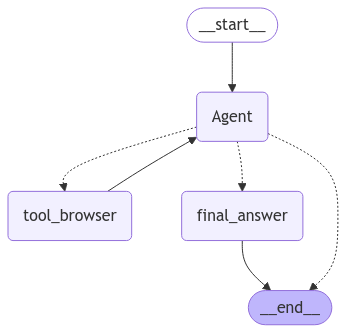

In [64]:
from langgraph.graph import StateGraph, END

## start the graph
workflow = StateGraph(State)

## add Agent node
workflow.add_node(node="Agent", action=node_agent) 
workflow.set_entry_point(key="Agent")  #<--user query

## add Tools nodes
for k in dic_tools.keys():
    workflow.add_node(node=k, action=node_tool)

## conditional_edges from Agent
workflow.add_conditional_edges(source="Agent", path=conditional_edges)

## normal_edges to Agent
for k in dic_tools.keys():
    if k != "final_answer":
        workflow.add_edge(start_key=k, end_key="Agent")

## end the graph
workflow.add_edge(start_key="final_answer", end_key=END)
g = workflow.compile()

## plot
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(Image(
    g.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)
))

In [66]:
state = {'user_q':q,
         'chat_history':history, 
         'lst_res':[], 
         'output':{} }

In [67]:
## 1) invoke function
out = g.invoke(input=state)
agent_out = out['output'].tool_output

--- node_agent ---
[{'content': '\n'
             'You know everything, you must answer every question from the '
             'user, you can use the list of tools provided to you.\n'
             'Your goal is to provide the user with the best possible answer, '
             'including key information about the sources and tools used.\n'
             '\n'
             'Note, when using a tool, you provide the tool name and the '
             'arguments to use in JSON format. \n'
             'For each call, you MUST ONLY use one tool AND the response '
             'format must ALWAYS be in the pattern:\n'
             '```json\n'
             '{"name":"<tool_name>", "parameters": '
             '{"<tool_input_key>":<tool_input_value>}}\n'
             '```\n'
             'Remember, do NOT use any tool with the same query more than '
             'once.\n'
             "Remember, if the user doesn't ask a specific question, you MUST "
             'use the `final_answer` tool directl

In [68]:
## 2) stream function
steps = g.stream(input=state) 
for n,step in enumerate(steps):
    print("--- step", n, "---")
    print(step)


--- node_agent ---
[{'content': '\n'
             'You know everything, you must answer every question from the '
             'user, you can use the list of tools provided to you.\n'
             'Your goal is to provide the user with the best possible answer, '
             'including key information about the sources and tools used.\n'
             '\n'
             'Note, when using a tool, you provide the tool name and the '
             'arguments to use in JSON format. \n'
             'For each call, you MUST ONLY use one tool AND the response '
             'format must ALWAYS be in the pattern:\n'
             '```json\n'
             '{"name":"<tool_name>", "parameters": '
             '{"<tool_input_key>":<tool_input_value>}}\n'
             '```\n'
             'Remember, do NOT use any tool with the same query more than '
             'once.\n'
             "Remember, if the user doesn't ask a specific question, you MUST "
             'use the `final_answer` tool directl